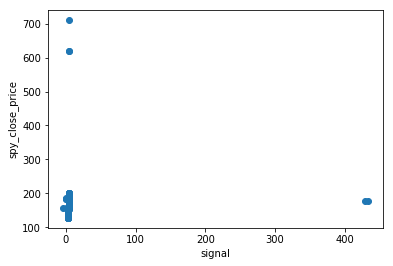


The first thing that was done was drop any row that had NaN value.

The graph shows that there are few extreme outliers that will have an impact on the accuracy of the regression 

count    667.000000
mean       5.166603
std       23.392818
min       -3.802670
25%        3.418083
50%        3.893689
75%        4.408313
max      432.961165
Name: signal, dtype: float64

Take a look at the outliers which are shown as min and max numbers. The min is a negative number and I changed it to absolute value making it positive. The reason for that is that the absolute value of the number was very close to the value at 50% so it seemed like a reasonable fix. 

count    667.000000
mean       5.178005
std       23.390293
min        0.004560
25%        3.418568
50%        3.893689
75%        4.408313
max      432.961165
Name: signal, dtype: float64

The max value for signal is 432.961165. Since this is an extreme outlier, this will have a negative impact on the R^2 value of the regression model. So 

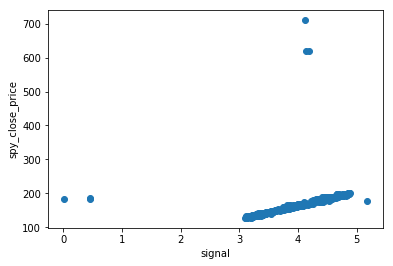

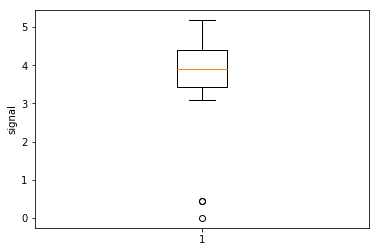


If you look at the boxplot of the signal feature, there are some outliers but they will not be changed. The reason for that is because they're reasonable outliers that could provide important information. It's desirable to preserve as much data as we can.

count    667.000000
mean     163.169369
std       39.210384
min      127.495000
25%      140.880000
50%      159.750000
75%      181.500000
max      710.310000
Name: spy_close_price, dtype: float64


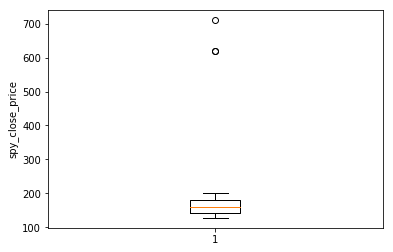

The spy_close_price has outliers as well, but we'll leave the spy_close_price for now.


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
import os
from sklearn.model_selection import train_test_split

def signal_pos(data, feature, minMax):
    if(minMax == 'min' or minMax == 'max'):
        signal = data[feature].describe().loc[minMax]
        if(feature == 'signal'):
            bool_signal = np.isclose(data.signal, signal)
            index = data.loc[bool_signal].signal.index[0]
            return index
        elif(feature == 'spy_close_price'):
            bool_signal = np.isclose(data.spy_close_price, signal)
            index = data.loc[bool_signal].signal.index[0]
            return index
    return None

def max_spy_close_price_pos(data):
    max_spy_close_price = data['spy_close_price'].describe().loc['max']
    bool_spy_close_price = np.isclose(data.spy_close_price, max_spy_close_price)
    index = data.loc[bool_spy_close_price].spy_close_price.index[0]
    return index

def relative_filepath(path):
    wk_dir = os.path.dirname(os.path.realpath('__file__'))
    filepath = os.path.join(wk_dir, path)
    return filepath

def scatter_plot(x, y, xlabel, ylabel, show=True):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(x, y)
    if(show):
        plt.show()
    return

def describe_data(feature):
    description = feature.describe()
    print(description)
    return

def describe_swap_value(data, feature, value, minMax, describe=True):
    pos = signal_pos(data, feature, minMax)
    data.loc[pos, feature] = value
    if(describe):
        describe_data(data[feature])
    return data

# data cleaning

filepath = relative_filepath('data.csv')
data = pd.read_csv(filepath, dtype = {'signal' : float, 'spy_close_price' : float}, parse_dates=['date'])
data = data.dropna(how='any', axis=0)

scatter_plot(x=data['signal'], y=data['spy_close_price'], xlabel='signal', ylabel='spy_close_price')

print('\nThe first thing that was done was drop any row that had NaN value.')
print('\nThe graph shows that there are few extreme outliers that will have an impact on the accuracy of the regression \n')

describe_data(data['signal'])

print('\nTake a look at the outliers which are shown as min and max numbers. ' + 
      'The min is a negative number and I changed it to absolute value making it positive. The reason for that is' +
      ' that the absolute value of the number was very close to the value at 50% so it seemed like a reasonable fix. \n')

pos = signal_pos(data, 'signal', 'min')
describe_swap_value(data, 'signal', abs(data.loc[pos, 'signal']), 'min')

print('\nThe max value for signal is 432.961165. Since this is an extreme outlier, this will have a negative impact on the R^2 value' 
      + ' of the regression model. So what we\'ll do is change the signal to the mean value to preserve the spy_close_price.')

describe_swap_value(data, 'signal', abs(data['signal'].mean()), 'max')

print('\nAgain the max value will be changed for the same reasoning as above.\n')
describe_swap_value(data, 'signal', abs(data['signal'].mean()), 'max')

print('\nThe data currently looks like this: \n')

scatter_plot(x=data['signal'], y=data['spy_close_price'], xlabel='signal', ylabel='spy_close_price')

plt.ylabel('signal')
plt.boxplot(data['signal'])
plt.show()

print('\nIf you look at the boxplot of the signal feature, there are some outliers but they will not be changed. The reason '+
      'for that is because they\'re reasonable outliers that could provide important information. It\'s desirable to preserve as ' +
      'much data as we can.\n')

describe_data(data['spy_close_price'])

plt.ylabel('spy_close_price')
plt.boxplot(data['spy_close_price'])
plt.show()

print('The spy_close_price has outliers as well, but we\'ll leave the spy_close_price for now.')



We're going to try the simple linear regression using 30% of the data as the test data and the rest as training data


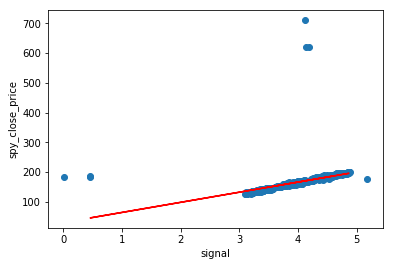

The coefficient for the linear regression is [[ 33.96659887]]
The intercept is [ 30.57896335]
The coefficient of determination R^2 is 0.244925340353

Currently the R^2 is not a good value for the linear regression because of the outliers.
The graph shows the best fit line for the regression as well as existence of linear correlation between the signal and spy_close_price
To improve the R^2 value we'll change the value of the outliers instead of removing them completely.


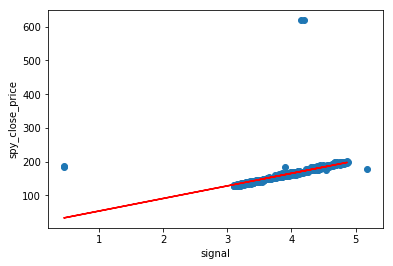


The coefficient of determination R^2 after changing two outliers is 0.239397140664
The R^2 is still not good enough we want to be as accurate as possible for the general case of simple linear regression


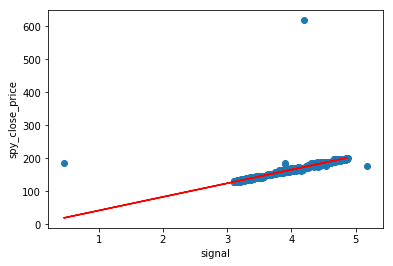


The coefficient of determination R^2 after changing two outliers is 0.673073294628
It's getting better but let's try one more time


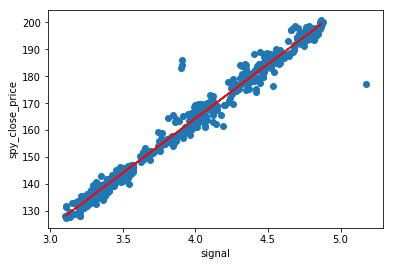

The coefficient for the linear regression is [[ 40.32199098]]
The intercept is [ 3.02056676]
The coefficient of determination R^2 is 0.981621422021

From this we can conclude that a "unit" increase in the X (signal) is associated with a 21.15539006 "unit" increase in the y (spy_close_price).
Although we have a high coefficient of determination, we have high bias and will not be able to predict outliers well since we reduced the variance each time we changed the data.
If you want to be able to predict the outliers somewhat but lose some of the accuracy for predicting the general case, you would have to use a model that has lower R^2 value.


In [24]:
from sklearn import linear_model
from sklearn.preprocessing import normalize

def mean_outlier(data):
    pos = signal_pos(data, 'signal', 'min')
    data.loc[pos, 'signal'] = data['signal'].mean()

    pos = signal_pos(data, 'spy_close_price', 'max')
    data.loc[pos, 'spy_close_price'] = data['spy_close_price'].mean()
    
    return data

def plot_linear_regression(data):
    
    X = data['signal'].values.reshape(-1,1)
    Y = data['spy_close_price'].values.reshape(-1,1)
    #X = scale(X)
    #Y = scale(Y)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

    reg = LinearRegression(normalize=True)
    reg.fit(X_train , y_train)
    
    scatter_plot(x=data['signal'], y=data['spy_close_price'], xlabel='signal', ylabel='spy_close_price', show=False)
    plt.plot(X_test, reg.predict(X_test), 'r')
    plt.show()
    return reg, X_test, y_test

# predictive analysis
print('We\'re going to try the simple linear regression using 30% of the data as the test data and the rest as training data')

reg, X_test, y_test = plot_linear_regression(data)

print('The coefficient for the linear regression is', reg.coef_)
print('The intercept is', reg.intercept_)
print('The coefficient of determination R^2 is', reg.score(X_test, y_test))
print('\nCurrently the R^2 is not a good value for the linear regression because of the outliers.')
print('The graph shows the best fit line for the regression as well as existence of linear correlation between the signal and spy_close_price')
print('To improve the R^2 value we\'ll change the value of the outliers instead of removing them completely.')

data = mean_outlier(data)

reg, X_test, y_test = plot_linear_regression(data)

print('\nThe coefficient of determination R^2 after changing two outliers is', reg.score(X_test, y_test))
print('The R^2 is still not good enough we want to be as accurate as possible for the general case of simple linear regression')

data = mean_outlier(data)

reg, X_test, y_test = plot_linear_regression(data)
print('\nThe coefficient of determination R^2 after changing two outliers is', reg.score(X_test, y_test))
print('It\'s getting better but let\'s try one more time')


data = mean_outlier(data)

reg, X_test, y_test = plot_linear_regression(data)

print('The coefficient for the linear regression is', reg.coef_)
print('The intercept is', reg.intercept_)
print('The coefficient of determination R^2 is', reg.score(X_test, y_test))

print('\nFrom this we can conclude that a "unit" increase in the X (signal) is associated with a 21.15539006 "unit" increase in the y'
     + ' (spy_close_price).')
print('Although we have a high coefficient of determination, we have high bias and will not be able to predict outliers well ' +
      'since we reduced the variance each time we changed the data.')
print('If you want to be able to predict the outliers somewhat but lose some of the accuracy for predicting the general case,' 
      + ' you would have to use a model that has lower R^2 value.')

First we drop the signal column from the dataframe. We're interested in predicting the future values for spy_close_price using previously observed values of spy_close_price. The date is necessary to check if the time series is stationary.


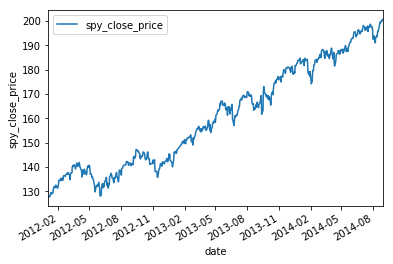

This is the plot of the spy_close_price over the time. We can see that there's a general increase in spy_close_price as time passes.
Next we do a test to see if the time series is stationary. That means that it has a particular behaviour over time. This is important since if that is true, there's a good possibility that the future will have the same behaviour.
The test we're using is the Dickey-Fuller test.

Results of Dickey-Fuller Test:

Test Statistic                  -0.060527
p-value                          0.953231
#Lags Used                       5.000000
Number of Observations Used    661.000000
Critical Value (1%)             -3.440282
Critical Value (5%)             -2.865922
Critical Value (10%)            -2.569104
dtype: float64

In the Dickey-Fuller test, the null hypothesis is that the time series is not stationary.
The way we see if the hypothesis holds true is by comparing the value of the test statistic and the critical values.
If the test statistic is less than the 

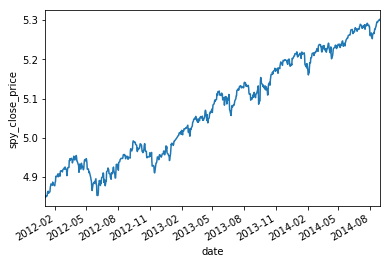

Next we use differencing to remove trend by taking the difference of the observation at a particular time with that at the previous time.


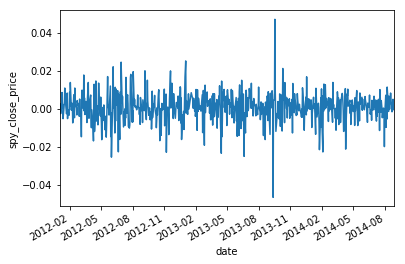


Results of Dickey-Fuller Test after :

Test Statistic                -1.406022e+01
p-value                        3.065919e-26
#Lags Used                     4.000000e+00
Number of Observations Used    6.610000e+02
Critical Value (1%)           -3.440282e+00
Critical Value (5%)           -2.865922e+00
Critical Value (10%)          -2.569104e+00
dtype: float64

The test statistic is lower than critical value of 1% so we can say that with 99% confidence that the time series is stationary.


In [25]:
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# time series
print('First we drop the signal column from the dataframe. We\'re interested in predicting the future values for spy_close_price using' 
     + ' previously observed values of spy_close_price. The date is necessary to check if the time series is stationary.')
data.drop(labels='signal', axis=1, inplace=True)
data = data.set_index(keys='date')
data.plot()
plt.ylabel('spy_close_price')
plt.show()

print('This is the plot of the spy_close_price over the time. We can see that there\'s a general increase in spy_close_price as'
     + ' time passes.')

data = data.iloc[:,0]

print('Next we do a test to see if the time series is stationary. That means that it has a particular behaviour over time.' +
      ' This is important since if that is true, there\'s a good possibility that the future will have the same behaviour.')
print('The test we\'re using is the Dickey-Fuller test.')

test = adfuller(data)

print('\nResults of Dickey-Fuller Test:\n')
output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in test[4].items():
    output['Critical Value (%s)'%key] = value
print(output)
print('\nIn the Dickey-Fuller test, the null hypothesis is that the time series is not stationary.')
print('The way we see if the hypothesis holds true is by comparing the value of the test statistic and the critical values.')
print('If the test statistic is less than the critical value, we can reject the null hypthesis and say that the time series is' +
     ' stationary.')
print('In this case the test statistic is greater than the critical value so we accept the null hypthesis. Therefore we have to' +
     ' try to make the time series stationary by reducing the trend using transformation.')
print('\nFirst apply the transformation, which we\'re doing by taking the log, to penalize the higher values more than smaller ones')
data_log = np.log(data)
data_log.plot()
plt.ylabel('spy_close_price')
plt.show()

print('Next we use differencing to remove trend by taking the difference of the observation at a particular time with that at the '
      + 'previous time.')
data_log_diff = data_log - data_log.shift()
data_log_diff.plot()
plt.ylabel('spy_close_price')
plt.show()
data_log_diff.dropna(inplace=True)
test = adfuller(data_log_diff)
print('\nResults of Dickey-Fuller Test after :\n')
output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in test[4].items():
    output['Critical Value (%s)'%key] = value
print(output)

print('\nThe test statistic is lower than critical value of 1% so we can say that with 99% confidence that the time series is stationary.')

Now we're going to use ARIMA model for the time series, but before that we need to find the parameters for it.
The parameters we need to know are p, d, q. We can use the partial autocorrelation function and autocorrelation function to find p and q value respectively.


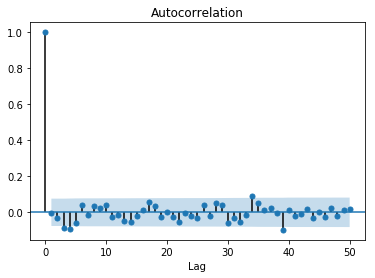

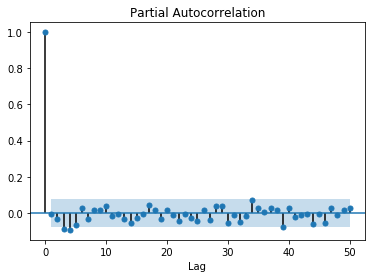

From looking at the plots, the blue square represent the 95% confidence intervals. For both of the plots, there is no value outside the confidence intervals excluding lag=0. So for both p and q, the value will be zero.


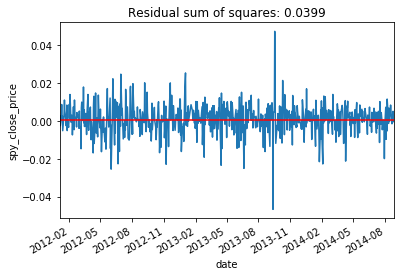

The residual sum of squares is very close to 0 so it means that the model fits the data well
Next we'll take the differenciation and the log of the ARIMA model so we can predict the original data


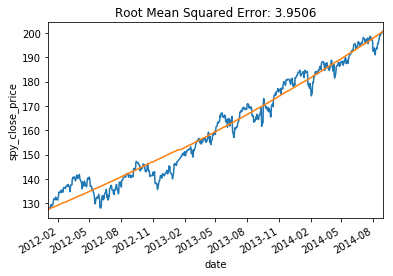

The root mean squared error represents the measure of differences between values predicted by the model and the actual values.In this case, the conclusion is that the model fits the data well to be able to predict time series.


In [21]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

#forecasting time series

print('Now we\'re going to use ARIMA model for the time series, but before that we need to find the parameters for it.')
print('The parameters we need to know are p, d, q. We can use the partial autocorrelation function and autocorrelation function to find' +
     ' p and q value respectively.')

plot_acf(data_log_diff, lags=50)
plt.xlabel('Lag')
plt.show()
plot_pacf(data_log_diff, lags=50)
plt.xlabel('Lag')
plt.show()

print('From looking at the plots, the blue square represent the 95% confidence intervals. For both of the plots, there is no value'
     + ' outside the confidence intervals excluding lag=0. So for both p and q, the value will be zero. For the d, it is the number' +
     ' of differencing, which we only did first order so d=1.')

model = ARIMA(data_log, order=(0, 1, 0))
results_AR = model.fit(disp=False)  
data_log_diff.plot()
plt.plot(results_AR.fittedvalues, color='red')
plt.title('Residual sum of squares: %.4f'% sum((results_AR.fittedvalues-data_log_diff)**2))
plt.ylabel('spy_close_price')
plt.show()

print('The residual sum of squares is very close to 0 so it means that the model fits the data well')
print('Next we\'ll take the differenciation and the log of the ARIMA model so we can predict the original data')

predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(data_log.iloc[0], index=data_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
data.plot()
plt.plot(predictions_ARIMA)
plt.title('Root Mean Squared Error: %.4f'% np.sqrt(sum((predictions_ARIMA-data)**2)/len(data)))
plt.ylabel('spy_close_price')
plt.show()

print('The root mean squared error represents the measure of differences between values predicted by the model and the actual values.' )